In [3]:
import os
import numpy as np
import pandas as pd

# load data '../../chars.csv'
chars = pd.read_csv('../characters_freq.csv', sep=',', encoding='utf-8')
words = pd.read_csv('../vocabulary_freq.csv', sep=',', encoding='utf-8')

In [4]:
# new dataframe
df = pd.DataFrame(columns=['page', 'chars', 'words',
                  'level', 'pinyin', 'part_of_speech'])

page = 0
for index, row in chars.iterrows():

    page += 1

    df.loc[index, 'page'] = page
    df.loc[index, 'chars'] = row['character']
    df.loc[index, 'level'] = row['level']
    df.loc[index, 'pinyin'] = row['pinyin']

In [5]:
df['old_chars'] = ''
for page, row in df.iterrows():
    cum_chars = df.loc[:page, 'chars'].str.cat(sep=', ')
    df.at[page, 'old_chars'] = cum_chars

In [6]:
def find_words(df, words, num_chars_interval=(2, 10), max_page=-1):
    for page, row in df.iterrows():
        chars = row['old_chars']
        contains = words['word'].apply(lambda x: all(
            char in chars for char in x) and num_chars_interval[0] <= len(x) <= num_chars_interval[1])

        df.at[page, 'words'] = words[contains]['word'].values.tolist()
        # remove duplicates
        df.at[page, 'words'] = list(set(df.at[page, 'words']))

        # print(
        #     f"Page {row['page']}:\n\tChars: {chars}\n\tWords: {len(df.at[page, 'words'])}\n")

        # stop at max_page
        if row['page'] == max_page:
            break


find_words(df, words, num_chars_interval=(2, 10))

In [7]:
# Define the order
level_order = ['一级', '二级', '三级', '四级', '五级', '六级', '高等']

# Sort the dataframe
df['level'] = pd.Categorical(df['level'], level_order)
df.sort_values(['level', 'page'], inplace=True)

# Save to csv
# df.to_csv('guide.csv', sep=',', encoding='utf-8', index=False)

In [8]:
import pandas as pd

# Assuming df and 'old_chars' is a correct DataFrame with relevant columns set up properly.
# Convert 'words' column to a list of words if it is a string representation.
if isinstance(df.at[0, 'words'], str):
    # Update this split according to actual delimiter.
    df['words'] = df['words'].apply(lambda x: x.split(', '))

# Assume 'old_chars' is separated by comma and space as in the provided code.
if 'old_chars' in df.columns:
    # Update this split according to actual delimiter.
    df['old_chars'] = df['old_chars'].apply(lambda x: x.split(', '))
else:
    # If 'old_chars' column does not exist, create empty lists.
    df['old_chars'] = [[] for _ in range(len(df))]

# Create a cumulative set of old characters introduced up to each row.
cumulative_old_chars = set()
df['cumulative_old_chars'] = pd.Series(dtype='object')
for i in range(len(df)):
    cumulative_old_chars.update(df.at[i, 'old_chars'])
    df.at[i, 'cumulative_old_chars'] = cumulative_old_chars.copy()

# Define a function to find new words.


def find_new_words(row):
    return [word for word in row['words'] if row['chars'] in word and word not in row['cumulative_old_chars']]


# Apply the function to get new_words
df['new_words'] = df.apply(find_new_words, axis=1)

# Reorder the columns
df2 = df[['level', 'chars', 'pinyin', 'new_words']]

# Save to CSV
df2.to_csv('guide.csv', sep=',', encoding='utf-8', index=False)

In [9]:
# save every level (as numbers) to csv
for i, level in enumerate(level_order, 1):
    df2[df2['level'] == level].to_csv(
        f'guide_{i}.csv', sep=',', encoding='utf-8', index=False)

In [10]:
# find same char but different pinyin
homophones = df2[df2.duplicated(subset=['chars'], keep=False)]
# sort by level and chars
homophones.sort_values(['chars', 'level'], inplace=True)
homophones.to_csv('homophones.csv', sep=',', encoding='utf-8', index=False)

/tmp/ipykernel_110494/3648982129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homophones.sort_values(['chars', 'level'], inplace=True)


In [40]:

import pandas as pd
from openai import OpenAI

# Load the data
radicals = pd.read_csv('../radicals_freq.csv', sep=',', encoding='utf-8')
radicals['Embedding'] = ''

# Initialize the OpenAI client with the correct API key
openai_object = OpenAI(api_key=api_key)

for index, row in radicals.iterrows():
    radical = row['Key'][0]
    response = openai_object.embeddings.create(
        input=radical,
        model="text-embedding-ada-002"
    )
    embedding_vector = response
    radicals.at[index, 'Embedding'] = response.data[0].embedding

# Remember to save the modified DataFrame if necessary
radicals.to_csv('radical_embeddings.csv', index=False)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 214 samples in 0.000s...
[t-SNE] Computed neighbors for 214 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 214 / 214
[t-SNE] Mean sigma: 0.162539
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.619514
[t-SNE] KL divergence after 1350 iterations: 0.705355


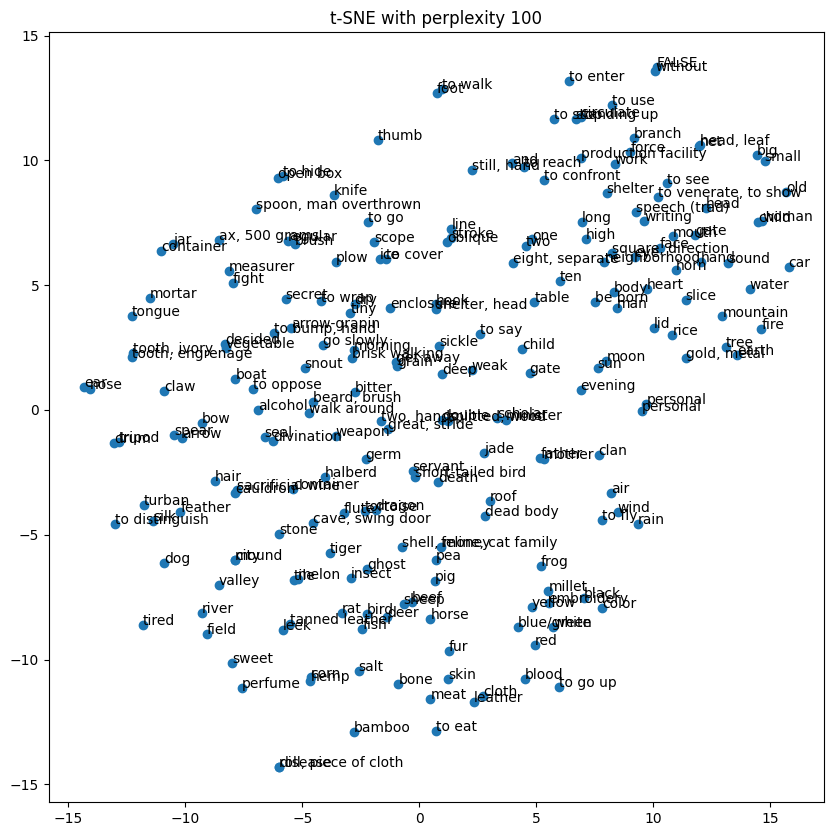

In [78]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load the data
radicals = pd.read_csv('radical_embeddings.csv', sep=',', encoding='utf-8')

# Convert the string representation of the embeddings to a list of floats
radicals['Embedding'] = radicals['Embedding'].apply(lambda x: [float(i) for i in x[1:-1].split(', ')])
# Extract the embeddings
embeddings = np.array(radicals['Embedding'].tolist())

# Reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, perplexity=40, n_iter=10000, verbose=1)
tsne_results = tsne.fit_transform(embeddings)

# Set the size of the plot
plt.figure(figsize=(10, 10))

# Plot the t-SNE results
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

# Add labels
for i, txt in enumerate(radicals['English']):
    plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]))

# Set the title and show the plot
plt.title(f"t-SNE with perplexity {temp}")
plt.show()



[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 214 samples in 0.000s...
[t-SNE] Computed neighbors for 214 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 214 / 214
[t-SNE] Mean sigma: 0.145382
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.706467


[t-SNE] KL divergence after 3500 iterations: 1.016797


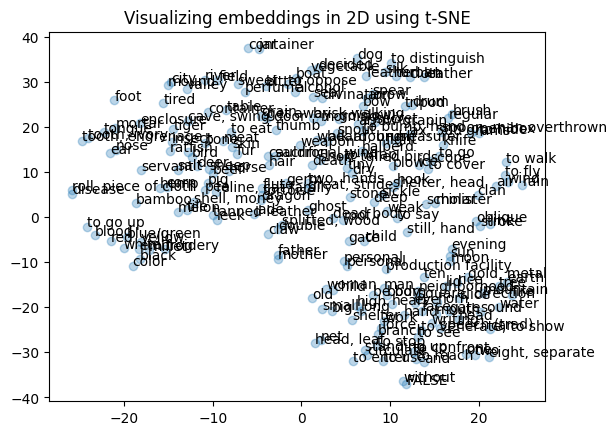

<Figure size 2000x2000 with 0 Axes>

In [94]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200, n_iter=10000, verbose=1)
vis_dims2 = tsne.fit_transform(embeddings)
x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

# Add labels
radicals = pd.read_csv('radical_embeddings.csv', sep=',', encoding='utf-8')
for i, txt in enumerate(radicals['English']):
    plt.annotate(txt, (x[i], y[i]))

plt.scatter(x, y, alpha=0.3)
plt.title("Visualizing embeddings in 2D using t-SNE")
plt.figure(figsize=(20, 20))
plt.show()
